# V2X 데이터 전처리

In [4]:
import numpy as np
import cv2
import torch
import pandas as pd
import re
import pickle as pkl
import json
import glob
import shutil
import os
import json
import pathlib as pl
from typing import List, Tuple, Dict, Union, Optional
from tqdm import trange, tqdm
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split

from modules.preprocessing import V2XPreprocessing
from modules.v2x import V2XData,V2XDataLabeled
from modules.metrics import *
from tsai.all import *
from tqdm import tqdm
from modules.RunTSAI import RunTSAI
from sklearn.utils import shuffle


data_path_8 = "./data/v2xfinal/8월s"
data_path_9 = "./data/v2xfinal/9월"
data_path_10 = "./data/v2xfinal/10월"
data_path_11 = "./data/v2xfinal/11월"
data_path_8s = "./data/v2xfinal/8월s"


## CSV, JSON 파일 경로 리스트 만들기
- CSV, JSON 파일을 한 경로에 담기
  - 8월s
  -  ㄴ CSV
  -  ㄴ JSON
  - 9월
  -  ㄴ CSV
  -  ㄴ JSON

In [7]:
# csv파일과 json파일을 각각 리스트로 가져옴
csv_files8s, json_files8s = V2XPreprocessing.get_csv_data(data_path_8s + "/CSV"), \
                            V2XPreprocessing.get_json_data(data_path_8s + "/JSON")
print(f"csv file count: {len(csv_files8s)}, json file count: {len(json_files8s)}")

csv file count: 557218, json file count: 557218


In [9]:
# csv파일과 json파일 리스트를 pickle로 저장
with open("pickles/8월s/CSV8s.pkl", "wb") as f:
    pkl.dump(csv_files8s, f)
with open("pickles/8월s/JSON8s.pkl", "wb") as f:
    pkl.dump(json_files8s, f)

In [10]:
# csv파일과 json파일 각 리스트를 pickle로 가져옴
with open("pickles/8월s/CSV8s.pkl", "rb") as f:
    csv_files8s = pkl.load(f)
with open("pickles/8월s/JSON8s.pkl", "rb") as f:
    json_files8s = pkl.load(f)

In [11]:
# CSV파일 concat, pickle로 저장
df8s = [pd.read_csv(f) for f in tqdm(csv_files8s, desc="Reading csv files")]
df8s = pd.concat(df8s, ignore_index=True)
with open("pickles/8월s/df8scsv.pkl", "wb") as f:
    pkl.dump(df8s, f)

Reading csv files: 100%|██████████| 557218/557218 [26:47<00:00, 346.58it/s]  


In [12]:
# CSV파일 concat pickle로 가져옴
with open("pickles/8월s/df8scsv.pkl", "rb") as f:
    df8scsv = pkl.load(f)

In [13]:
df8scsv.head()

ISSUE_DATE   LATITUDE   LONGITUDE  HEADING  SPEED VEHICLE_CLASS  \
0  20220801120000  36.475947  127.277996       61     18      FFE80A0B   
1  20220801120001  36.475972  127.278049       61     21      FFE80A0B   
2  20220801120002  36.476001  127.278114       61     25      FFE80A0B   
3  20220801120003  36.476038  127.278194       61     29      FFE80A0B   
4  20220801120004  36.476076  127.278279       61     33      FFE80A0B   

   BRAKE_STATUS  ACC  
0             0   -1  
1             0   -1  
2             0   -1  
3             0   -1  
4             0   -1

In [14]:
# NaN값 제거
df8scsv = df8scsv.dropna()
# counts rows if there's NaN value
df8scsv.isna().sum()

ISSUE_DATE       0
LATITUDE         0
LONGITUDE        0
HEADING          0
SPEED            0
VEHICLE_CLASS    0
BRAKE_STATUS     0
ACC              0
dtype: int64

In [15]:
for col in df8scsv.columns:
    if col in ["VEHICLE_CLASS"]:
        continue
    # print if value is not float or int
    print(f"{col}: {df8scsv[col].apply(lambda x: type(x) not in [float, int]).sum()}")

ISSUE_DATE: 0
LATITUDE: 0
LONGITUDE: 0
HEADING: 0
SPEED: 0
BRAKE_STATUS: 0
ACC: 0


In [ ]:
# exclude ["ISSUE_DATE"] column, values to int on ["VEHICLE_CLASS", "HEADING"], str on ["VEHICLE_ID", "VEHICLE_TYPE"], float on others

for col in df8scsv.columns:
    if col in ["ISSUE_DATE"]:
        df8scsv.drop(col, axis=1, inplace=True)
    elif col in ["VEHICLE_CLASS", "HEADING"]:
        df8scsv[col] = df8scsv[col].astype(int)
    elif col in ["VEHICLE_ID", "VEHICLE_TYPE"]:
        df8scsv[col] = df8scsv[col].astype(str)
    else:
        df8scsv[col] = df8scsv[col].astype(float)

In [16]:
# value counts of VEHICLE_ID VEHICLE_CLASS VEHICLE_TYPE
for col in df8scsv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        print(f"{col}: {df8scsv[col].value_counts()}")
        print(f"{col} unique: {df8scsv[col].unique().shape}", end="\n\n")

VEHICLE_CLASS: FFE80A0B    2678400
FFE80C76    1446890
FFE8117A    1446890
Name: VEHICLE_CLASS, dtype: int64
VEHICLE_CLASS unique: (3,)



In [19]:
# categorize ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"] columns
from sklearn.preprocessing import LabelEncoder

for col in df8scsv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        encoder = LabelEncoder()
        encoder.fit(df8scsv[col])
        categorized_array = encoder.transform(df8scsv[col])
        print(categorized_array)
        df8scsv[col] = categorized_array

[0 0 0 ... 0 0 0]


In [20]:
# index reset
df8scsv.reset_index(drop=True, inplace=True)
df8scsv

LATITUDE   LONGITUDE  HEADING  SPEED  VEHICLE_CLASS  BRAKE_STATUS  \
0        36.475947  127.277996       61   18.0              0             0   
1        36.475972  127.278049       61   21.0              0             0   
2        36.476001  127.278114       61   25.0              0             0   
3        36.476038  127.278194       61   29.0              0             0   
4        36.476076  127.278279       61   33.0              0             0   
...            ...         ...      ...    ...            ...           ...   
5572175  36.495079  127.306541       28    0.0              0             0   
5572176  36.495079  127.306541       28    0.0              0             0   
5572177  36.495079  127.306541       28    0.0              0             0   
5572178  36.495079  127.306541       28    0.0              0             0   
5572179  36.495079  127.306541       28    0.0              0             0   

         ACC  
0         -1  
1         -1  
2         -1  
3         -1  
4         -1  
...      ...  
5572175   -1  
5572176   -1  
5572177   -1  
5572178   -1  
5572179   -1  

[5572180 rows x 7 columns]

# Standarization

In [21]:
# standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df8scsv_scaled = scaler.fit_transform(df8scsv)
df8scsv_scaled = pd.DataFrame(df8scsv_scaled, columns=df8scsv.columns)
df8scsv_scaled

LATITUDE  LONGITUDE   HEADING     SPEED  VEHICLE_CLASS  BRAKE_STATUS  \
0        0.088553  -0.431846 -0.726400  0.694614      -0.936781           0.0   
1        0.088657  -0.430990 -0.726400  0.899831      -0.936781           0.0   
2        0.088783  -0.429938 -0.726400  1.173453      -0.936781           0.0   
3        0.088939  -0.428637 -0.726400  1.447075      -0.936781           0.0   
4        0.089102  -0.427269 -0.726400  1.720698      -0.936781           0.0   
...           ...        ...       ...       ...            ...           ...   
5572175  0.170353   0.030145 -1.071918 -0.536687      -0.936781           0.0   
5572176  0.170353   0.030145 -1.071918 -0.536687      -0.936781           0.0   
5572177  0.170353   0.030145 -1.071918 -0.536687      -0.936781           0.0   
5572178  0.170353   0.030145 -1.071918 -0.536687      -0.936781           0.0   
5572179  0.170353   0.030145 -1.071918 -0.536687      -0.936781           0.0   

         ACC  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
5572175  0.0  
5572176  0.0  
5572177  0.0  
5572178  0.0  
5572179  0.0  

[5572180 rows x 7 columns]

# CSV 파일 Dataframe pickle로 저장

In [22]:
with open("pickles/8월s/df8s_scaled.pkl", "wb") as f:
    pkl.dump(df8scsv_scaled, f)

In [50]:
df8scsv_scaled = pd.read_pickle("pickles/8월s/df8s_scaled.pkl") # load pickle

In [24]:
df8scsv_scaled_npy = df8scsv_scaled.values.reshape(df8scsv_scaled.shape[0]//10, 10, 7)
df8scsv_scaled_npy = df8scsv_scaled_npy.transpose(0, 2, 1)

In [25]:
# save numpy array as npy file
np.save("pickles/8월s/X_8s.npy", df8scsv_scaled_npy) 

In [26]:
df8scsv_scaled_npy = np.load("pickles/8월s/X_8s.npy") # load npy file

In [27]:
print(df8scsv_scaled_npy.shape)
df8scsv_scaled_npy[:2]

(557218, 7, 10)


array([[[ 0.08855324,  0.08865671,  0.08878285,  0.08893934,
          0.08910224,  0.08927968,  0.08947124,  0.0896474 ,
          0.08982783,  0.09001297],
        [-0.43184633, -0.43099017, -0.42993818, -0.42863694,
         -0.42726935, -0.42580304, -0.4242558 , -0.42287526,
         -0.42149148, -0.42006239],
        [-0.72639977, -0.72639977, -0.72639977, -0.72639977,
         -0.72639977, -0.72639977, -0.73687003, -0.74734029,
         -0.74734029, -0.73687003],
        [ 0.69461379,  0.89983054,  1.17345287,  1.44707521,
          1.72069754,  1.78910312,  1.85750871,  1.78910312,
          1.65229196,  1.51548079],
        [-0.9367815 , -0.9367815 , -0.9367815 , -0.9367815 ,
         -0.9367815 , -0.9367815 , -0.9367815 , -0.9367815 ,
         -0.9367815 , -0.9367815 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0. 

----------------------

# JSON

In [28]:
with open("pickles/8월s/JSON8s.pkl", "rb") as f:
    json_files8s = pkl.load(f)

In [29]:
# read json_file8[0]
with open(json_files8s[0], "r") as f:
    json_sample = json.load(f)
json_sample

{'Path': 'V_220801_C_A_FFE80A0B_004321',
 'Annotation': {'Vehicle_ID': 'FFE80A0B',
  'Turn': 'False',
  'Lane': 'False',
  'Speed': 'False',
  'Hazard': 'False'}}

In [59]:
df8s_json = pd.read_json(json_files8s[0])
# df8_json = df8_json['Annotation'][['Turn', 'Lane', 'Speed', 'Hazard']].to_frame().T
# values = df8_json.values.tolist()[0]
# values
df8s_json

Path Annotation
Hazard      V_220801_C_A_FFE809B4_000075.csv      False
Lane        V_220801_C_A_FFE809B4_000075.csv      False
Speed       V_220801_C_A_FFE809B4_000075.csv      False
Turn        V_220801_C_A_FFE809B4_000075.csv      False
Vehicle_ID  V_220801_C_A_FFE809B4_000075.csv   FFE809B4

In [34]:
json8s_list = []
cols = ['Turn', 'Lane', 'Speed', 'Hazard']
print(cols)

df8sjson = pd.DataFrame(columns=cols)
for i in trange(len(json_files8s)):
    with open(json_files8s[i], "r") as f:
        temp_json = json.load(f)
        temp_json = [temp_json['Annotation'][key] for key in temp_json['Annotation'].keys() if key in cols]
        json8s_list.append(temp_json)
        
# json8s_list = [x[:4] for x in json8s_list]
json8s_npy = np.array(json8s_list)

['Turn', 'Lane', 'Speed', 'Hazard']


100%|██████████| 557218/557218 [07:37<00:00, 1217.37it/s]


In [35]:
np.save("pickles/8월s/y_8s.npy", json8s_npy)

In [36]:
json8s_npy = np.load("pickles/8월s/y_8s.npy")
json8s_npy.shape

(557218, 4)

In [37]:
json8s_npy

array([['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False'],
       ['Left', 'False', 'False', 'False'],
       ...,
       ['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False']], dtype='<U7')

# Time series classification

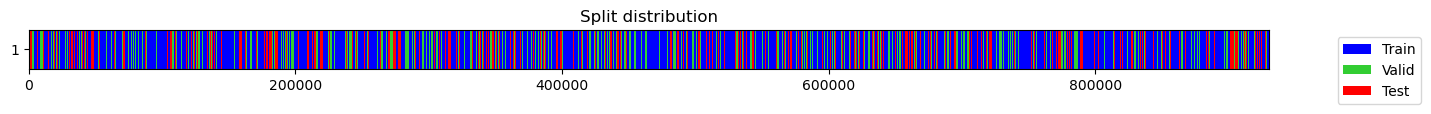

In [2]:
from tsai.all import *
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM, # LSTM, MLSTM_Plus
    lr = 1e-3,
    n_epochs = 200,
)

X_8s = np.load("pickles/8월s/X_8s.npy")
y_8s = np.load("pickles/8월s/y_8s.npy")
split_all = get_splits(y_8s, shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)
split = split_all
split


In [ ]:
# learner_turn = RunTSAI.multivariate_classification(X, y, split, config)
# curr_time = datetime.now().strftime("%Y%m%d_%H%M")
# learner_turn.save_all(path=f"models/turn_{curr_time}", dls_fname='dls_turn', model_fname='model_turn_MLSTM_FCNPlus', learner_fname='learner_turn')

In [8]:
X_8s.shape, y_8s.shape

((930000, 9, 10), (930000, 4))

In [6]:
###
from collections import Counter
print("turn:", np.unique(y_8s[:, 0]))
print("lane:", np.unique(y_8s[:, 1]))
print("speed:", np.unique(y_8s[:, 2]))
print("hazard:", np.unique(y_8s[:, 3]))
print("turn:", Counter(y_8s[:, 0]))
print("lane:", Counter(y_8s[:, 1]))
print("speed:", Counter(y_8s[:, 2]))
print("hazard:", Counter(y_8s[:, 3]))

turn: ['False' 'Left' 'Reverse' 'Right']
lane: ['False']
speed: ['Acc' 'False' 'Hbrk']
hazard: ['False' 'True']
turn: Counter({'False': 876495, 'Right': 26666, 'Left': 25099, 'Reverse': 1740})
lane: Counter({'False': 930000})
speed: Counter({'False': 929248, 'Hbrk': 553, 'Acc': 199})
hazard: Counter({'False': 926813, 'True': 3187})


In [19]:
label_counts_multi = collections.Counter([z for r in y_8s for z in r])
label_counts_multi

vocab, counts = zip(*label_counts_multi.items())
N = len(y_8s)
pw = [(N-c)/c if c > 0 else 1.0 for c in counts]   # compute weights

tfms = [None, [MultiCategorize(vocab=vocab), OneHotEncode]]
dsets = TSDatasets(X_8s, y_8s, tfms=tfms, splits=split, inplace=False)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], shuffle_train=False, batch_tfms=[TSStandardize()])


In [13]:
X_8s = np.load("pickles/8월s/X_8s.npy")
y_8s = np.load("pickles/8월s/y_8s.npy")

config_default = AttrDict(
    batch_tfms = TSStandardize(),
    architecture = LSTM, # LSTM, LSTM_FCNPlus, MLSTM_Plus
    n_epochs = 10,
)

split_all = get_splits(y_8s, shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)
split = split_all

def multiclass_classification(X, y, split, config):
    y_list=y[:, 0].tolist()


    tfms = [None, [Categorize]]

    dsets = TSDatasets(X, y_list, tfms=tfms, splits=split, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], 
                                batch_tfms=[TSStandardize()], num_workers=0)
    model = create_model(LSTM_FCNPlus, dls=dls)

    learn = Learner(dls, model, metrics=[accuracy, F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')])

    # Train model
    learn.fit_one_cycle(10)
    learn.recorder.plot_metrics()
    return learn

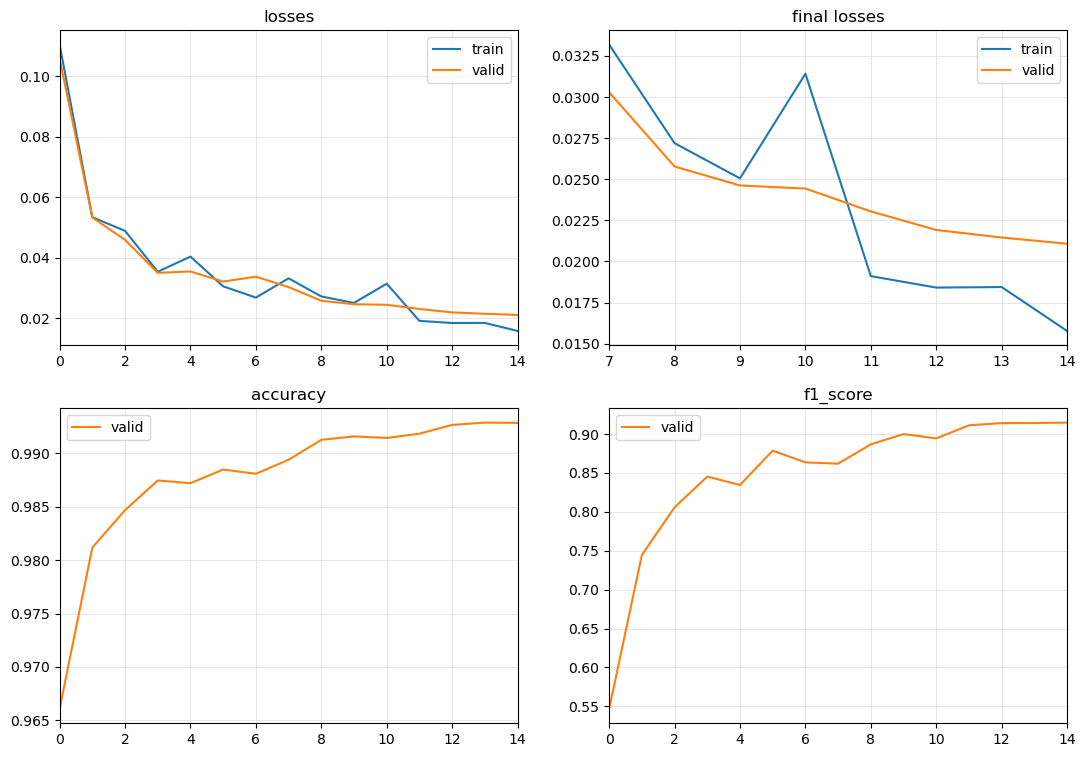

In [14]:
learn.recorder.plot_metrics()

In [15]:
dls = learn.dls
dls_valid = dls.valid
test_probas, test_targets, test_preds = learn.get_preds(dl=dls_valid, with_decoded=True)

In [18]:
learn.save_all("models/V2X_8s/turn")

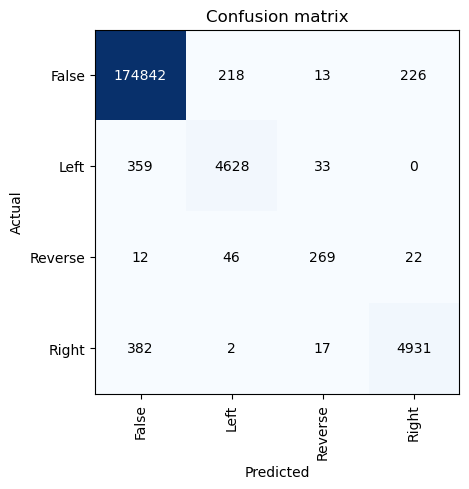

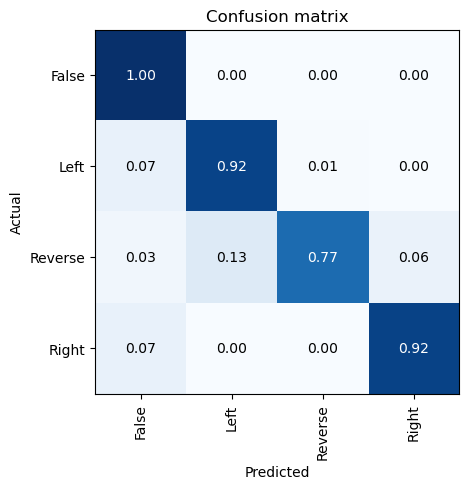

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_confusion_matrix(normalize=True)

# 훈련 검증

## 8월s

In [3]:
X = np.load("pickles/8월s/X_8s.npy")
y = np.load("pickles/8월s/y_8s.npy")
y_turn = y[:, 0]
y_speed = y[:, 2]
y_hazard = y[:, 3]

config = AttrDict(
    batch_tfms = TSStandardize(),
    architecture = LSTM_FCNPlus, # LSTM, LSTM_FCNPlus, MLSTM_Plus
    n_epochs = 10,
)

RunTSAI.target_label_counter(y)
split_all = get_splits(y, shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)

Counter({'False': 876495, 'Right': 26666, 'Left': 25099, 'Reverse': 1740})
Counter({'False': 930000})
Counter({'False': 929248, 'Hbrk': 553, 'Acc': 199})
Counter({'False': 926813, 'True': 3187})


[Counter({'False': 876495, 'Left': 25099, 'Right': 26666, 'Reverse': 1740}),
 Counter({'False': 930000}),
 Counter({'False': 929248, 'Hbrk': 553, 'Acc': 199}),
 Counter({'False': 926813, 'True': 3187})]

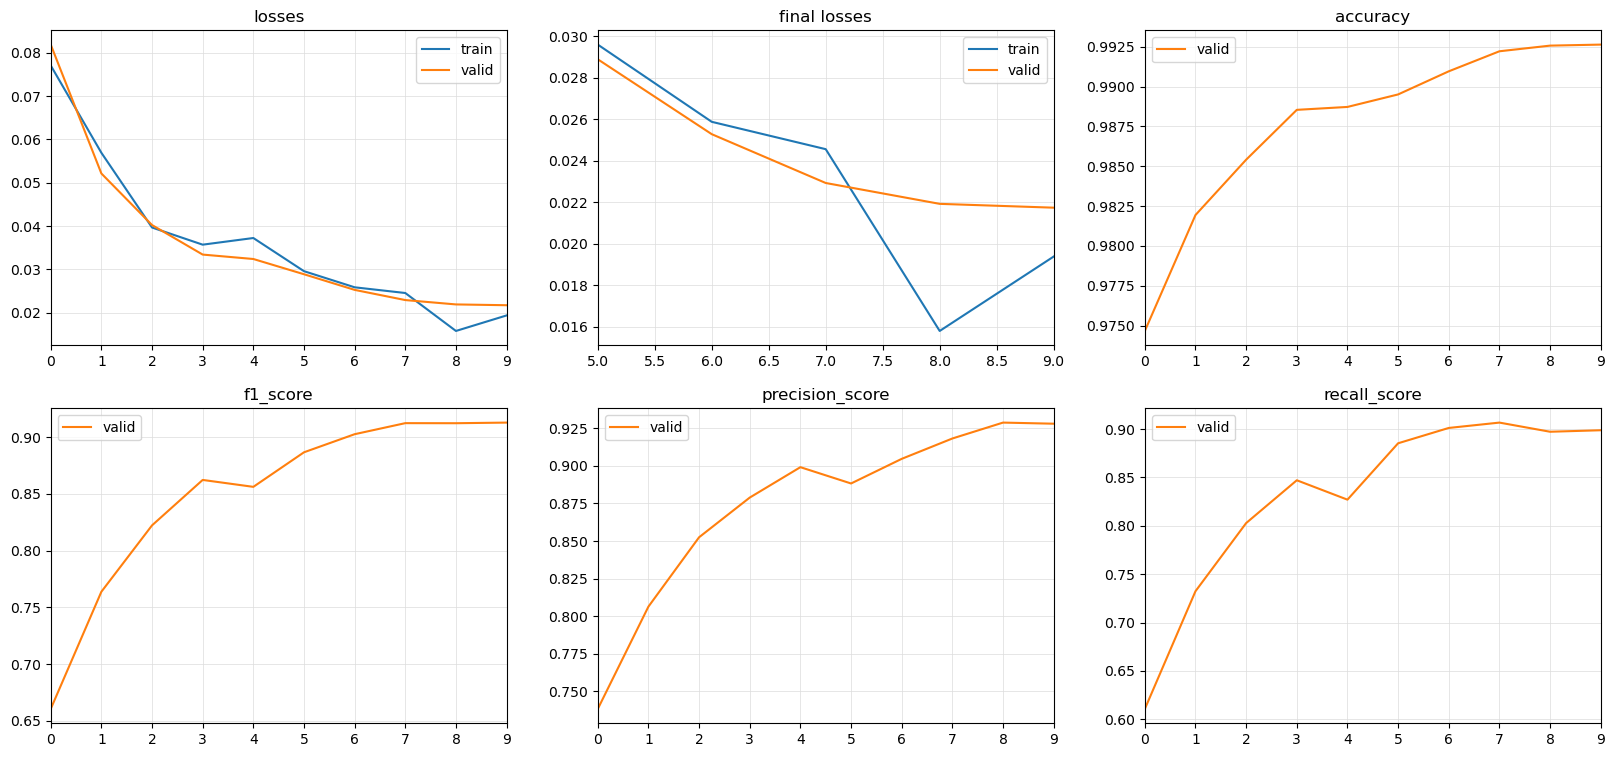

In [9]:
learn_turn = RunTSAI.multiclass_classification(X, y_turn, split_all, config, save_path = "models/V2X_8s/turn")

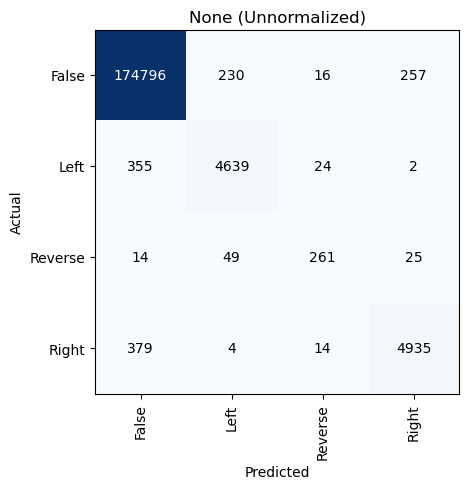

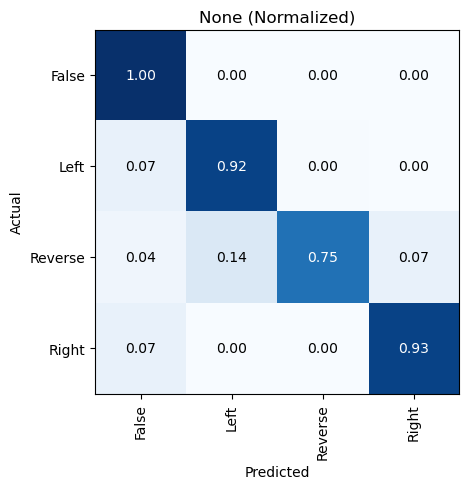

In [10]:
RunTSAI.plot_confusion_matrix(learn_turn)

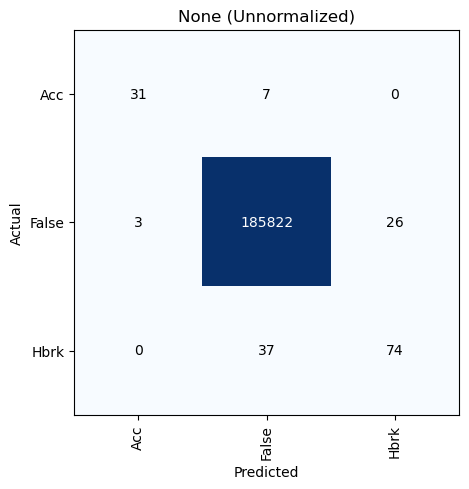

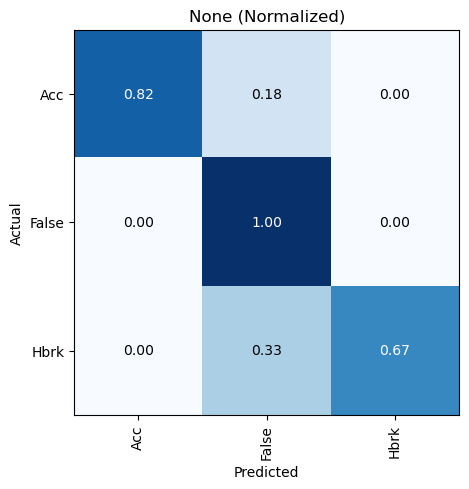

In [4]:
learn_speed = RunTSAI.multiclass_classification(X, y_speed, split_all, config, save_path = "models/V2X_8s/speed")
RunTSAI.plot_confusion_matrix(learn_speed)

## 9월

Counter({'Fals': 1274127, 'Righ': 38008, 'Left': 35376, 'Reve': 2489})
Counter({'Fals': 1350000})
Counter({'Fals': 1348923, 'Hbrk': 796, 'Acc': 281})
Counter({'Fals': 1345730, 'True': 4270})


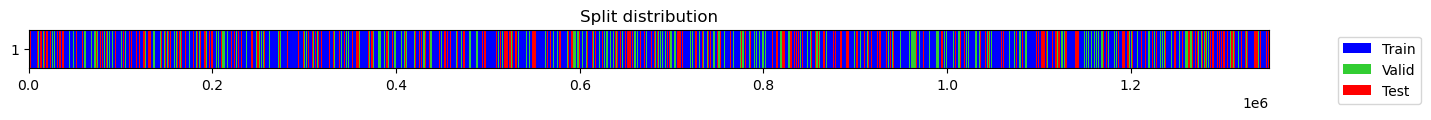

In [11]:
X = np.load("pickles/9월/X_9.npy")
y = np.load("pickles/9월/y_9.npy")
y9_turn = y[:, 0]
y9_speed = y[:, 2]
y9_hazard = y[:, 3]

config = AttrDict(
    batch_tfms = TSStandardize(),
    architecture = LSTM_FCNPlus, # LSTM, LSTM_FCNPlus, MLSTM_Plus
    n_epochs = 10,
)

RunTSAI.target_label_counter(y)
split_all = get_splits(y9_turn, shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)
split_all

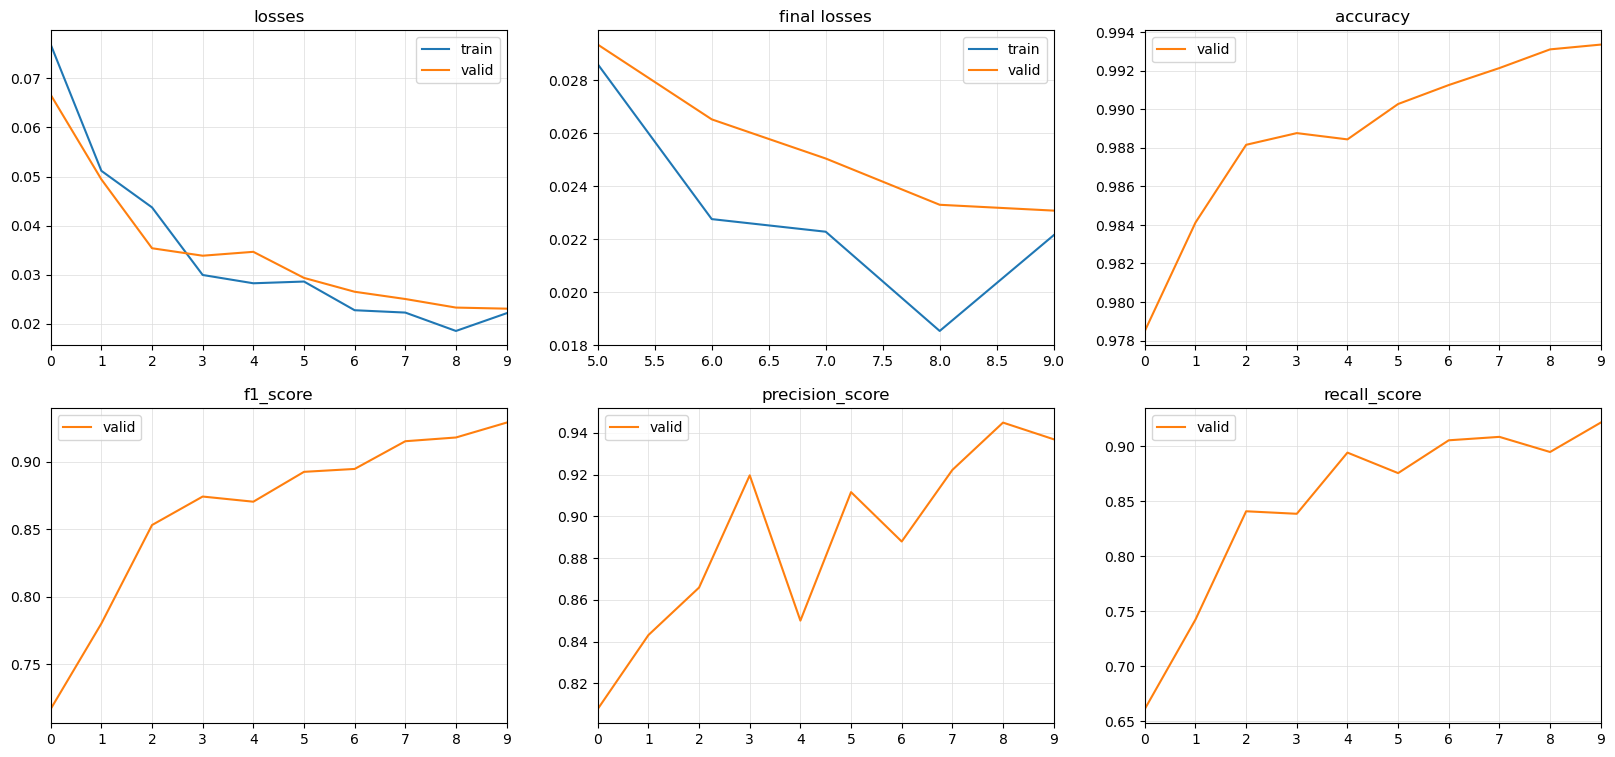

In [16]:
learn9_turn = RunTSAI.multiclass_classification(X, y9_turn, split_all, config, save_path = "models/V2X_9/turn")

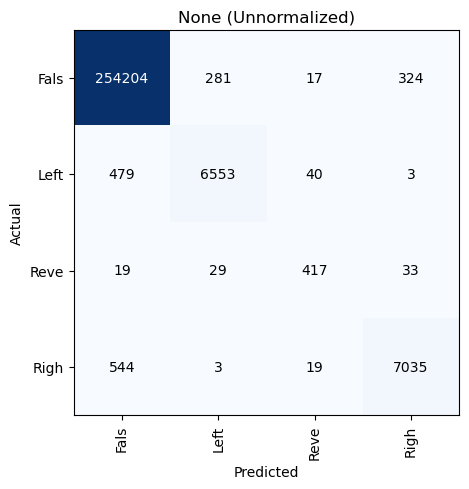

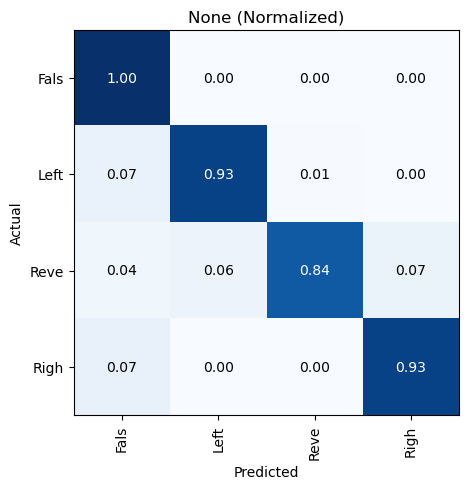

In [17]:
RunTSAI.plot_confusion_matrix(learn9_turn)

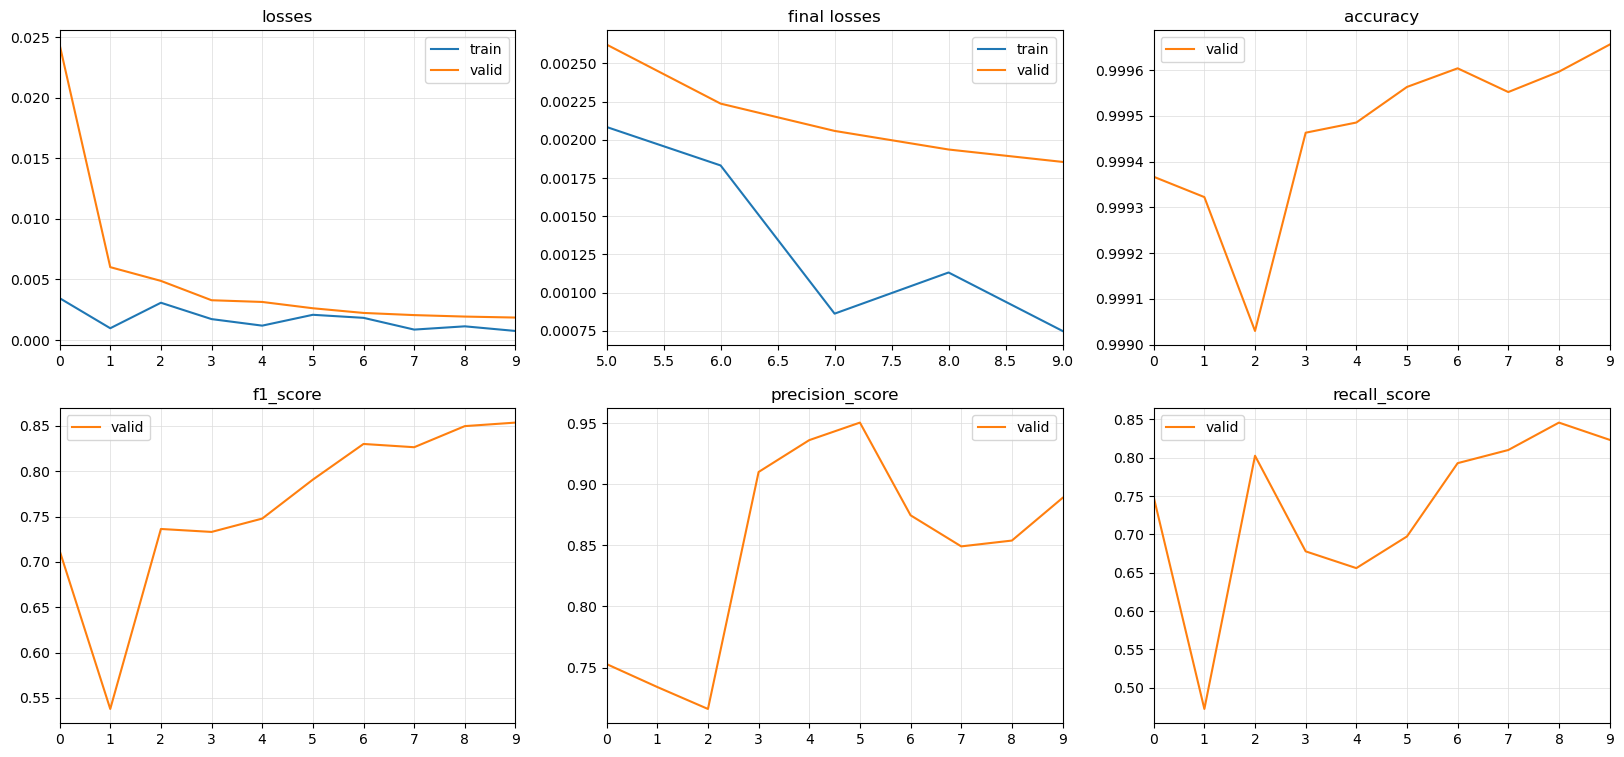

In [18]:
learn9_speed = RunTSAI.multiclass_classification(X, y9_speed, split_all, config, save_path = "models/V2X_9/speed")

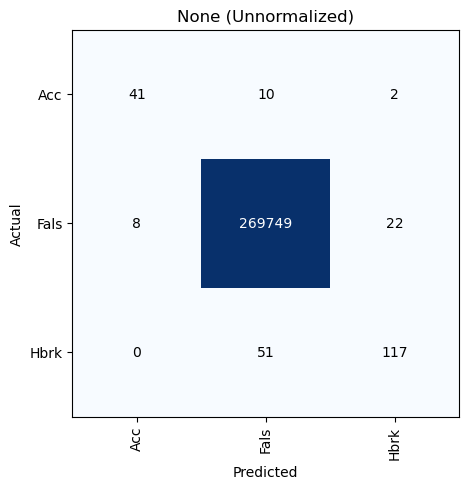

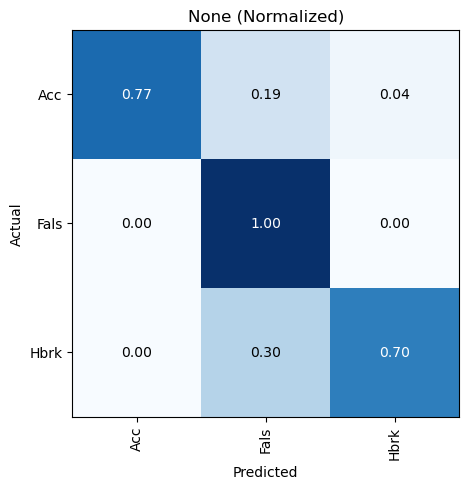

In [19]:
RunTSAI.plot_confusion_matrix(learn9_speed)

# Save trained model

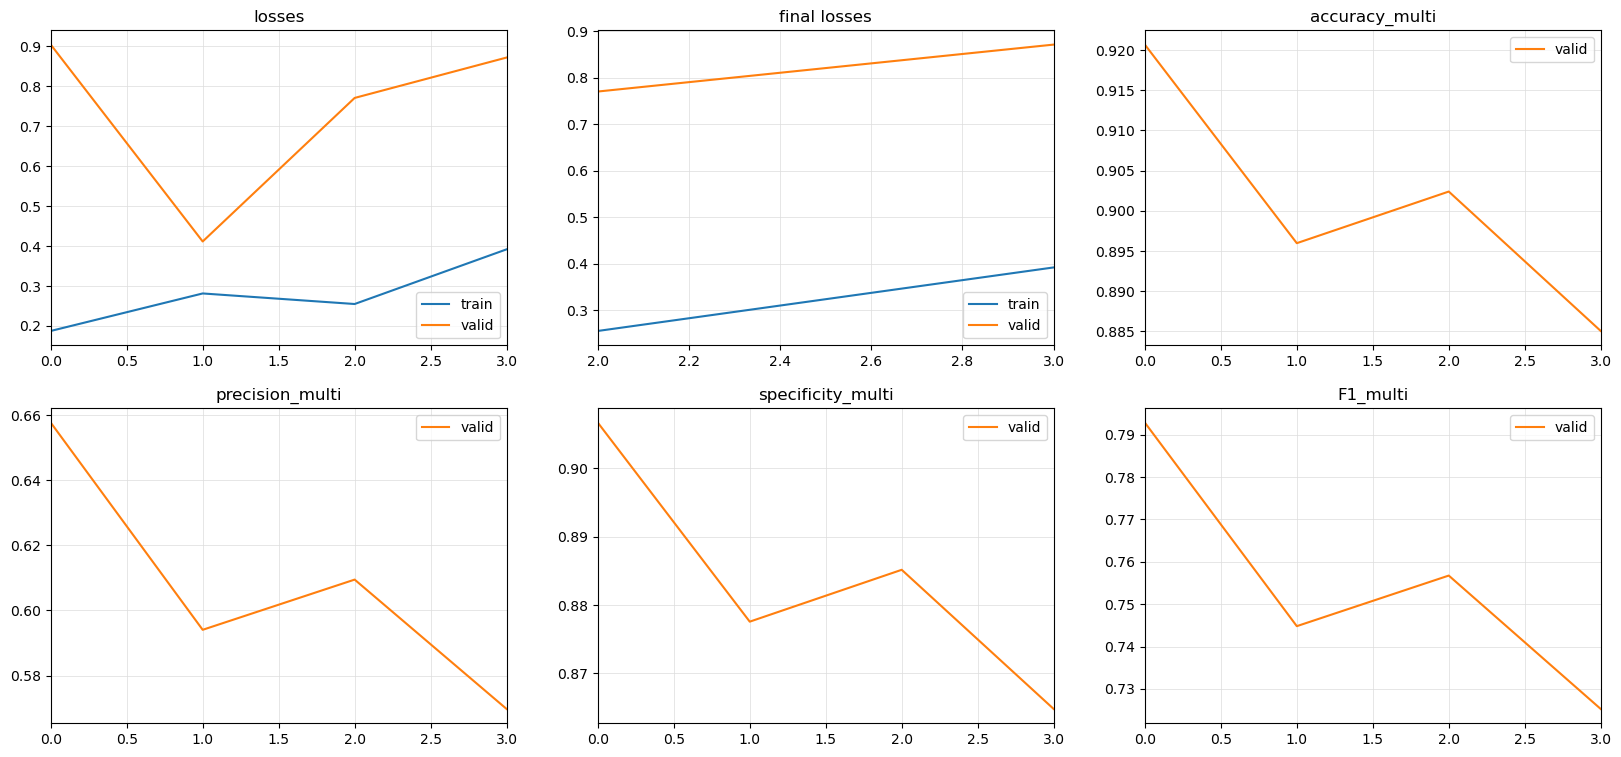

In [39]:
learn.recorder.plot_metrics()
learn.save_all("models/V2X_8s")

# Load model, get prediction

In [43]:
learn = load_learner_all(path="models/V2X_8s", dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
dls_valid = dls.valid
test_probas, test_targets, test_preds = learn.get_preds(dl=dls_valid, with_decoded=True)

In [44]:
print(test_probas[0])
print(test_targets[0])
print(test_preds[0])

TensorBase([0.0000e+00, 1.0000e+00, 4.9602e-03, 2.2658e-02, 5.5846e-09,
            1.5983e-02, 6.2769e-01])
tensor([0., 1., 0., 0., 0., 0., 0.])
TensorBase([False,  True, False, False, False, False,  True])


-------------------